# Sentiment Model Building

What this model should do:

    - The model should be fed text from trade_chat_v3.csv. In this case, it will ONLY be fed Game catagorized text which was done in the previous model (classification model).

## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Modeling imports
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score
from sklearn.model_selection import train_test_split, cross_val_score
import time

from functions import TradeChat
tc = TradeChat()

SEED = 22

In [2]:
%store -r sm_df_token
df = sm_df_token

In [3]:
df = tc.down_sample(df, 'sentiment')
df

,date,time,text,sentiment,target,text_tokenized,joined_tokens
0,2/22/2022,8:08:08 PM,well penis,Negative,Game,"[well, penis]",well penis
1,2/23/2022,7:43:05 PM,new hunter set is kinda ass lmao,Negative,Game,"[new, hunter, set, kinda, ass, lmao]",new hunter set kinda ass lmao
2,2/22/2022,8:14:50 AM,prolly honestly 12 hours,Negative,Game,"[prolly, honestly, hours]",prolly honestly hours
3,2/22/2022,8:58:55 PM,pvp gear is the same??? the whole purpose of ...,Negative,Game,"[pvp, gear, whole, purpose, wow, pvp]",pvp gear whole purpose wow pvp
4,2/23/2022,1:05:25 AM,whats up with ogrimmar? cant tp there,Negative,Game,"[whats, ogrimmar, cant, tp]",whats ogrimmar cant tp
...,...,...,...,...,...,...,...
829,2/22/2022,8:14:50 AM,thanks bros,Other,Game,"[thanks, bros]",thanks bros
830,2/22/2022,6:10:41 PM,lol,Other,Game,[lol],lol
831,2/23/2022,11:02:13 AM,find the most expensive farmable resource and...,Other,Game,"[find, expensive, farmable, resource, go, farm]",find expensive farmable resource go farm
832,2/23/2022,6:50:05 PM,ddungeonss and quests,Other,Game,"[ddungeonss, quests]",ddungeonss quests


In [4]:
df.sentiment.value_counts()

Negative    417
Other       417
Name: sentiment, dtype: int64

In [5]:
X = df.joined_tokens
y = df.sentiment.replace(['Negative','Other'],[0,1])

model_perf = {}
model_labels = ['Negative', 'Non-negative']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, random_state=22)


In [7]:
def run_model(estimator, X_train, y_train, X_test, y_test, cv):

  start = time.time()
  pipe = Pipeline(
      [ ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', estimator)
      ])
  
  pipe.fit(X_train, y_train)
  end = time.time()

  cv_acc = round(np.mean(cross_val_score(pipe, X_train, y_train, cv= cv, scoring= 'accuracy')),4)
  cv_rec = round(np.mean(cross_val_score(pipe, X_train, y_train, cv= cv, scoring= 'recall')),4)


  y_pred = pipe.predict(X_test)

  test_acc = round(accuracy_score(y_pred, y_test), 4)
  test_rec = round(recall_score(y_pred, y_test), 4)
  
  runtime = round((end-start), 4)

  cv_dict = {'CV_Accuracy': cv_acc, 'CV_recall': cv_rec, 'Test_Accuracy': test_acc, 'Test_Recall': test_rec, 'Run Time': runtime}


  return( pipe, cv_dict, y_pred)

## Base Models

In [8]:
sgd = SGDClassifier(random_state=SEED)
svc = SVC(random_state=SEED)
lr = LogisticRegression(random_state=SEED)
nb = MultinomialNB()
rf = RandomForestClassifier(random_state=SEED)

models = {'SGD': sgd, 'SVC': svc, 'LogReg': lr, 'Naive': nb, 'RFC': rf}


Showing results for: SGD
{'Model': Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(random_state=22))]), 'Performace': {'CV_Accuracy': 0.664, 'CV_recall': 0.5784, 'Test_Accuracy': 0.7033, 'Test_Recall': 0.7283, 'Run Time': 0.016}}

Showing results for: SVC
{'Model': Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', SVC(random_state=22))]), 'Performace': {'CV_Accuracy': 0.688, 'CV_recall': 0.5624, 'Test_Accuracy': 0.7273, 'Test_Recall': 0.8052, 'Run Time': 0.058}}

Showing results for: LogReg
{'Model': Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(random_state=22))]), 'Performace': {'CV_Accuracy': 0.672, 'CV_recall': 0.5785, 'Test_Accuracy': 0.7081, 'Test_Recall': 0.7654, 'Run Time': 0.024}}

Showing results for: Naive
{'Model': Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer())

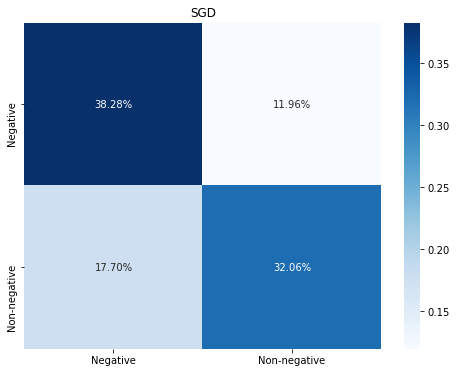

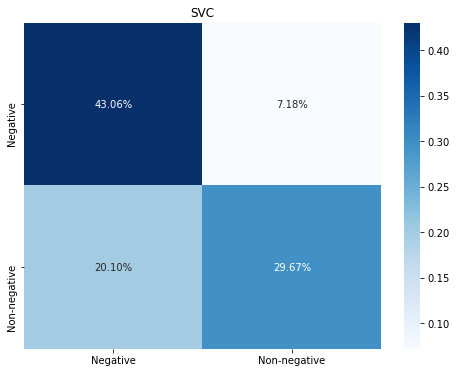

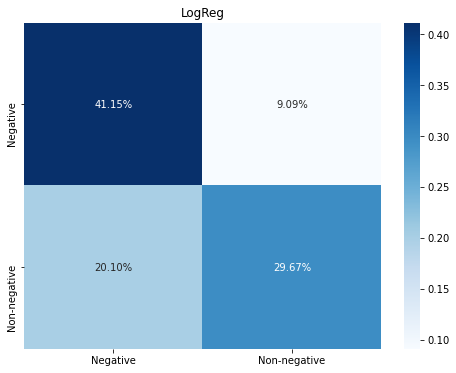

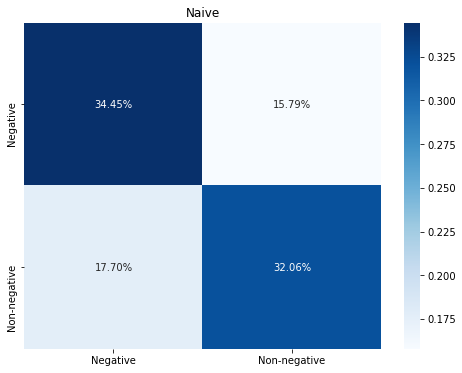

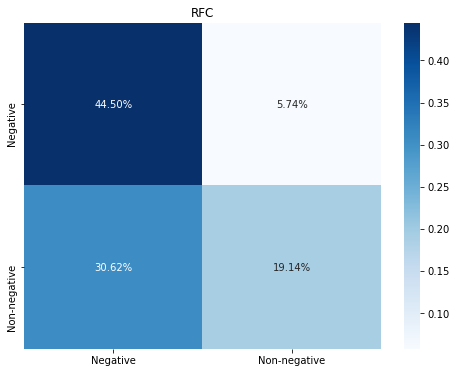

In [9]:
for key, model in models.items():

    model, cv_dict, y_pred = run_model(model, X_train, y_train, X_test, y_test, 5)
    model_perf[key] = {'Model': model, 'Performace': cv_dict}

    print(f'Showing results for: {key}')
    print(model_perf[key])
    print()

    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(8,6))

    sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues', xticklabels= model_labels, yticklabels= model_labels)
    ax.set_title(key);




In [10]:
y_test.value_counts()

0    105
1    104
Name: sentiment, dtype: int64

In [11]:
y_test.value_counts(normalize=True)

0    0.502392
1    0.497608
Name: sentiment, dtype: float64

## Tuned Models

In [12]:
sgd_params = {
    'vect__strip_accents':[None,'ascii','unicode'],
    'vect__lowercase': [True, False],
    'vect__ngram_range': [(1,1), (1,2), (2,2)],
    'tfidf__smooth_idf': [True, False],
    'clf__loss': ['hinge','log','modified_huber','squared_hinge'],
    'clf__max_iter':[1000,2000],
    'clf__class_weight': [None, 'balanced']
}

svc_params = {
    'vect__strip_accents':[None,'ascii','unicode'],
    'vect__lowercase': [True, False],
    'vect__ngram_range': [(1,1), (1,2), (2,2)],
    'tfidf__smooth_idf': [True, False],
    'clf__C': [1,5,10],
    'clf__kernel': ['linear','poly', 'rbf', 'sigmoid','precomputed'],
    'clf__degree': [3,6,9],
    'clf__gamma': ['auto', 'scale'],
    'clf__class_weight':[None, 'balanced']
}

lr_params = {
    'vect__strip_accents':[None,'ascii','unicode'],
    'vect__lowercase': [True, False],
    'vect__ngram_range': [(1,1), (1,2), (2,2)],
    'tfidf__smooth_idf': [True, False],
    'clf__C': [1,5,10],
    'clf__solver': ['liblinear','lbfgs', 'sag', 'saga','newton-cg'],
    'clf__class_weight': ['balanced', None],
    'clf__multi_class': ['auto', 'ovr', 'multinomial'],
    'clf__penalty':['l1','l2','elasticnet', 'none']
}

nb_params = {
    'vect__strip_accents':[None,'ascii','unicode'],
    'vect__lowercase': [True, False],
    'vect__ngram_range': [(1,1), (1,2), (2,2)],
    'tfidf__smooth_idf': [True, False]
}

rf_params = {
    'vect__strip_accents':[None,'ascii','unicode'],
    'vect__lowercase': [True, False],
    'vect__ngram_range': [(1,1), (1,2), (2,2)],
    'tfidf__smooth_idf': [True, False],
    'clf__n_estimators': [100,200,300,400,500],
    'clf__criterion': ['gini','entropy'],
    'clf__max_depth': [1,3,5],
    'clf__class_weight': [None,'balanced', 'balanced_subsample']
}

In [13]:
def grid_run(estimator, est_params, X_train, y_train, X_test, y_test, cv, score='accuracy'):

  model, cv_dict, y_pred = run_model(estimator, X_train, y_train, X_test, y_test, cv)

  grid = GridSearchCV(model,param_grid= est_params, cv=cv, verbose=1, n_jobs=-3, scoring= score)
  grid = grid.fit(X_train, y_train)

  return(grid)

In [14]:
model_params = {'SGD':{sgd:sgd_params}, 'SVC': {svc:svc_params}, 'LogReg': {lr:lr_params}, 'Naive': {nb:nb_params}, 'RFC': {rf:rf_params}}

In [15]:
# for key, estimators in model_params.items():
#   for estimator, params in estimators.items():

#     print('----------------------------------------------')
#     print(f'Now running {key} GridSearch')

#     grid = grid_run(estimator, params, X_train, y_train, X_test, y_test, 5, score='accuracy')

#     print()
#     print(grid.best_score_)
#     print(grid.best_params_)
#     print()

In [16]:
# {'clf__class_weight': None, 
# 'clf__loss': 'log', 
# 'clf__max_iter': 1000, 
# 'tfidf__smooth_idf': True, 
# 'vect__lowercase': True, 
# 'vect__ngram_range': (2, 2), 
# 'vect__strip_accents': None}

sgd = Pipeline(
    [   ('vect', CountVectorizer(ngram_range=(1,2))),
        ('tfidf', TfidfTransformer()),
        ('clf', SGDClassifier(loss='hinge', class_weight='balanced', random_state=SEED))
    ])


sgd.fit(X_train, y_train)

cv_acc = round(np.mean(cross_val_score(sgd, X_train, y_train, cv= 5, scoring= 'accuracy')),4)
cv_rec = round(np.mean(cross_val_score(sgd, X_train, y_train, cv= 5, scoring= 'recall')),4)


y_pred = sgd.predict(X_test)

test_acc = round(accuracy_score(y_pred, y_test), 4)
test_rec = round(recall_score(y_pred, y_test), 4)

print(cv_acc, cv_rec)
print(test_acc, test_rec)

0.6608 0.5751
0.6938 0.7381


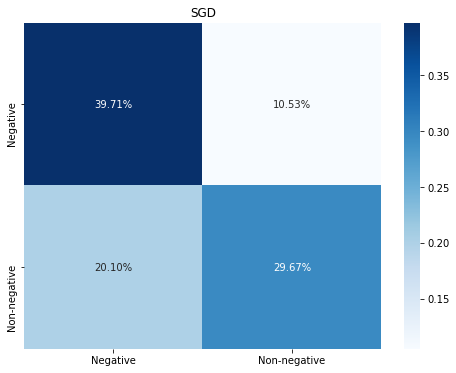

In [17]:
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))

sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues', xticklabels= model_labels, yticklabels= model_labels)
ax.set_title('SGD');

In [18]:
# {'clf__C': 1, 
# 'clf__class_weight': None, 
# 'clf__degree': 3, 
# 'clf__gamma': 'auto', 
# 'clf__kernel': 'poly', 
# 'tfidf__smooth_idf': True, 
# 'vect__lowercase': True, 
# 'vect__ngram_range': (1, 1), 
# 'vect__strip_accents': None}

svc = Pipeline(
    [   ('vect', CountVectorizer(ngram_range=(1,2))),
        ('tfidf', TfidfTransformer()),
        ('clf', SVC(C= 5, degree= 3, gamma= 'auto', kernel= 'linear', random_state=SEED))
    ])


svc.fit(X_train, y_train)

cv_acc = round(np.mean(cross_val_score(svc, X_train, y_train, cv= 5, scoring= 'accuracy')),4)
cv_rec = round(np.mean(cross_val_score(svc, X_train, y_train, cv= 5, scoring= 'recall')),4)


y_pred = svc.predict(X_test)

test_acc = round(accuracy_score(y_pred, y_test), 4)
test_rec = round(recall_score(y_pred, y_test), 4)

print(cv_acc, cv_rec)
print(test_acc, test_rec)

0.6752 0.5944
0.6842 0.7209


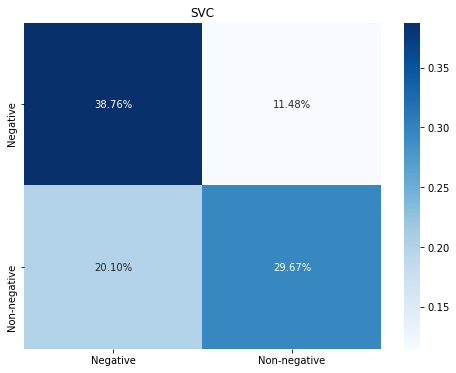

In [19]:
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))

sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues', xticklabels= model_labels, yticklabels= model_labels)
ax.set_title('SVC');

In [23]:
lg = Pipeline(
    [   ('vect', CountVectorizer(ngram_range=(1,2))),
        ('tfidf', TfidfTransformer()),
        ('clf', LogisticRegression(C= 5, class_weight = 'balanced', multi_class='auto', penalty= 'l2', solver='liblinear', random_state=SEED))
    ])


lg.fit(X_train, y_train)

cv_acc = round(np.mean(cross_val_score(lg, X_train, y_train, cv= 5, scoring= 'accuracy')),4)
cv_rec = round(np.mean(cross_val_score(lg, X_train, y_train, cv= 5, scoring= 'recall')),4)


y_pred = lg.predict(X_test)

test_acc = round(accuracy_score(y_pred, y_test), 4)
test_rec = round(recall_score(y_pred, y_test), 4)

print(cv_acc, cv_rec)
print(test_acc, test_rec)

0.68 0.5847
0.7177 0.7848


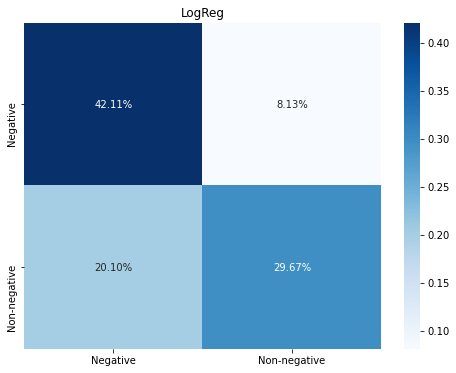

In [25]:
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))

sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues', xticklabels= model_labels, yticklabels= model_labels)
ax.set_title('LogReg');